<a href="https://colab.research.google.com/github/Evangenajohn/Early-Detection-of-Autism-in-Toddlers/blob/main/gaze_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install necessary libraries
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 963.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.7 which is inc

In [ ]:
!pip install --upgrade --force-reinstall numpy
!pip install --upgrade --force-reinstall mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
yfinance 0.2.59 requires protobuf<6,>=5.29.0, but you have protobuf 4.25.7 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached mediapipe-0.10.21-cp311-cp311-manyli

In [ ]:
# Step 2: Import libraries
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


In [ ]:
# Step 3: Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False,
                                   max_num_faces=1,
                                   refine_landmarks=True,
                                   min_detection_confidence=0.5,
                                   min_tracking_confidence=0.5)

In [ ]:
# Step 4: Helper function to calculate gaze direction
def estimate_gaze(landmarks, img_w, img_h):
    left_eye = [33, 133]  # Approx corners of left eye
    right_eye = [362, 263]  # Approx corners of right eye
    iris_center = 468  # Approx iris center landmark

    left_corner = np.array([landmarks[left_eye[0]].x * img_w,
                            landmarks[left_eye[0]].y * img_h])
    right_corner = np.array([landmarks[right_eye[0]].x * img_w,
                             landmarks[right_eye[0]].y * img_h])
    iris = np.array([landmarks[iris_center].x * img_w,
                     landmarks[iris_center].y * img_h])

    # Compute gaze ratio
    eye_line = right_corner - left_corner
    eye_line_length = np.linalg.norm(eye_line)
    iris_offset = iris - left_corner
    gaze_ratio = np.dot(iris_offset, eye_line) / (eye_line_length ** 2)

    return gaze_ratio  # Near 0.5 → center, < 0.4 → left, > 0.6 → right

In [ ]:
# STEP 1: Mount Google Drive and Load Video
import os
from google.colab import drive
drive.mount('/content/drive')
video_path = '/content/drive/MyDrive/videos_task/eye_contact1.mp4'

Mounted at /content/drive


In [ ]:
cap = cv2.VideoCapture(video_path)

eye_contact_count = 0
frame_count = 0
gaze_ratios = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        h, w, _ = frame.shape
        gaze_ratio = estimate_gaze(landmarks, w, h)
        gaze_ratios.append(gaze_ratio)

        # Assume gaze between 0.3–0.6 is "eye contact"
        if 0.3 <= gaze_ratio <= 0.6:
            eye_contact_count += 1
    else:
        # If no face detected, append None (or np.nan if you prefer)
        gaze_ratios.append(None)

cap.release()

In [ ]:
# Step 6: Compute percentage
eye_contact_percent = (eye_contact_count / frame_count) * 100
print(f"Eye contact maintained in {eye_contact_percent:.2f}% of the video.")

Eye contact maintained in 11.93% of the video.


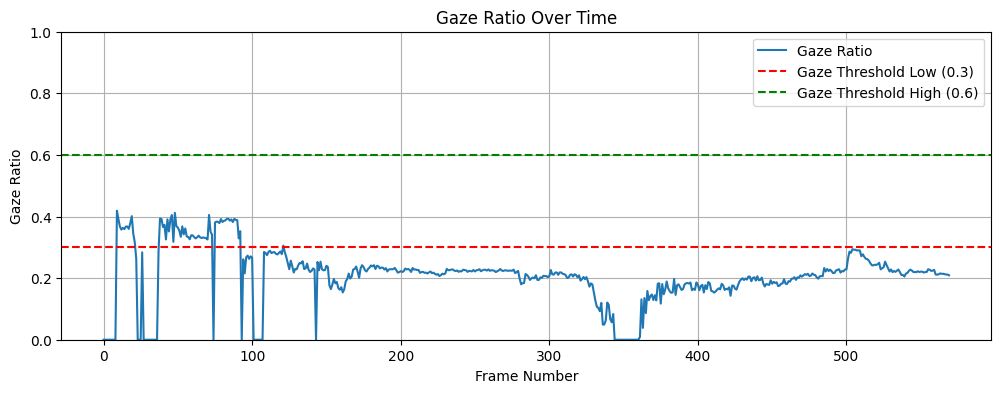

In [ ]:
# ---- 📈 Plot gaze over time ----
import matplotlib.pyplot as plt

# Replace None with 0 or np.nan for plotting
gaze_plot_data = [gr if gr is not None else 0 for gr in gaze_ratios]

plt.figure(figsize=(12, 4))
plt.plot(gaze_plot_data, label='Gaze Ratio')
plt.axhline(y=0.3, color='r', linestyle='--', label='Gaze Threshold Low (0.3)')
plt.axhline(y=0.6, color='g', linestyle='--', label='Gaze Threshold High (0.6)')
plt.title("Gaze Ratio Over Time")
plt.xlabel("Frame Number")
plt.ylabel("Gaze Ratio")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()